# TruthGen — Fake News Detection & Correction

**Authors:** Reema Ramachandra Kadechkar, Keerthi Turakapalli, Ashwin Shastry Paturi  
**Course:** DS510_03_IN: Artificial Intelligence for Data Science  
**Date:** 2025-09-03

This notebook consolidates the complete pipeline for **fake news detection** (TF‑IDF + Logistic Regression)
and **correction** (Generative AI via Gemini) into a single, polished deliverable suitable for final submission.

**What you can do here:**
1. Load and combine the `Fake.csv` & `True.csv` datasets
2. Preprocess text (normalize, clean, tokenize, remove stopwords, lemmatize)
3. Convert text → features with TF‑IDF (max_features=5000)
4. Train and evaluate a Logistic Regression baseline (Accuracy, Precision, Recall, F1, Confusion Matrix)
5. (Optional) Run the **Correction** stage to rewrite predicted‑fake articles using **Gemini** (Vertex AI)

> **Tip:** This notebook runs locally, but the **Correction** stage is designed for **Google Colab** + **Vertex AI**.

## 1) Setup & Imports

In [1]:
%pip install -q nltk scikit-learn matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

import nltk
from nltk.tokenize import wordpunct_tokenize           
from nltk.stem import WordNetLemmatizer, PorterStemmer  

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Paths in Codespaces
FAKE_DATASET = "/workspaces/DS510-Team-Project/Datasets/Fake.csv"
TRUE_DATASET = "/workspaces/DS510-Team-Project/Datasets/True.csv"

## 2) Load & Combine Dataset

In [3]:
def load_datasets(fake_path=FAKE_DATASET, true_path=TRUE_DATASET, seed=RANDOM_SEED):
    fake_df = pd.read_csv(fake_path)
    true_df = pd.read_csv(true_path)

    fake_df["label"] = 0  # Fake
    true_df["label"] = 1  # Real

    combined = pd.concat([fake_df, true_df], ignore_index=True)

    keep_cols = [c for c in ["title", "text", "subject", "date", "label"] if c in combined.columns]
    combined = combined[keep_cols]

    return combined.sample(frac=1.0, random_state=seed).reset_index(drop=True)

df = load_datasets()
print("Combined shape:", df.shape)
df.head()

Combined shape: (44898, 5)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


## 3) Text Preprocessing

In [4]:
# ---- Stopwords: try NLTK; fallback to a small built-in set if corpus missing ----
try:
    from nltk.corpus import stopwords
    STOPWORDS = set(stopwords.words("english"))
except Exception:
    # Minimal, effective fallback (add more if you like)
    STOPWORDS = set("""
a about above after again against all am an and any are as at be because been before being below
between both but by could did do does doing down during each few for from further had has have
having he he'd he'll he's her here here's hers herself him himself his how how's i i'd i'll i'm i've
if in into is it it's its itself let's me more most my myself nor of on once only or other ought our
ours ourselves out over own same she she'd she'll she's should so some such than that that's the
their theirs them themselves then there there's these they they'd they'll they're they've this those
through to too under until up very was we we'd we'll we're we've were what what's when when's where
where's which while who who's whom why why's with would you you'd you'll you're you've your yours yourself yourselves
""".split())

# ---- Normalizer: prefer WordNet lemmatizer if corpus present; else Porter stemmer (no data needed) ----
try:
    nltk.data.find("corpora/wordnet")
    USE_LEMMA = True
    _lemmatizer = WordNetLemmatizer()
    _stemmer = None
except LookupError:
    USE_LEMMA = False
    _lemmatizer = None
    _stemmer = PorterStemmer()

CLEAN_RE = re.compile(r"[^a-zA-Z\s]")

def clean_text(s: str) -> str:
    """Lowercase, keep letters/space, collapse whitespace."""
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = CLEAN_RE.sub(" ", s)
    return re.sub(r"\s+", " ", s).strip()

def preprocess_text(s: str) -> str:
    """
    Clean → tokenize (wordpunct_tokenize, no 'punkt' needed) → stopword filter →
    lemmatize (if wordnet available) else Porter stem (no corpora).
    """
    s = clean_text(s)
    tokens = wordpunct_tokenize(s)
    tokens = [t for t in tokens if t and t not in STOPWORDS]
    if USE_LEMMA:
        tokens = [_lemmatizer.lemmatize(t) for t in tokens]
    else:
        tokens = [_stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

def build_body_column(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    title = out.get("title", "").fillna("")
    text  = out.get("text", "").fillna("")
    out["body"] = (title + ". " + text).str.strip()
    return out

# Apply
df = build_body_column(df)
df["body_clean"] = df["body"].apply(preprocess_text)

print("Cleaned sample:")
print(df[["body", "body_clean"]].head())

Cleaned sample:
                                                body  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3  OOPS: Trump Just Accidentally Confirmed He Lea...   
4  Donald Trump heads for Scotland to reopen a go...   

                                          body_clean  
0  ben stein call th circuit court commit coup ta...  
1  trump drop steve bannon nation secur council w...  
2  puerto rico expect u lift jone act ship restri...  
3  oop trump accident confirm leak isra intellig ...  
4  donald trump head scotland reopen golf resort ...  


## 4) Train/Test Split, TF‑IDF, and Logistic Regression

In [5]:
from sklearn.pipeline import make_pipeline

# Features/labels
X = df["body_clean"].fillna("")
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

model = make_pipeline(
    TfidfVectorizer(max_features=5000, ngram_range=(1, 2)),
    LogisticRegression(
        max_iter=200,
        solver="liblinear",
        class_weight="balanced",
        random_state=RANDOM_SEED
    )
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

Accuracy : 0.9894
Precision: 0.9845
Recall   : 0.9935
F1-score : 0.9890

Classification Report:

              precision    recall  f1-score   support

           0     0.9940    0.9857    0.9898      4696
           1     0.9845    0.9935    0.9890      4284

    accuracy                         0.9894      8980
   macro avg     0.9892    0.9896    0.9894      8980
weighted avg     0.9895    0.9894    0.9894      8980



### Confusion Matrix

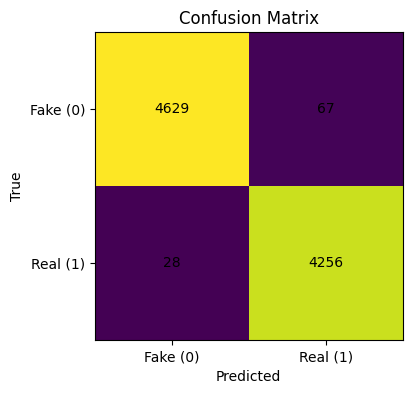

In [6]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cm)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(["Fake (0)", "Real (1)"])
ax.set_yticklabels(["Fake (0)", "Real (1)"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

ax.set_title("Confusion Matrix")
plt.show()

## 5) Keyword Inspection (TF‑IDF)

In [10]:
def top_terms(classifier, vectorizer, class_idx=1, top_k=20):
    # For LogisticRegression with liblinear, coef_ shape = (1, n_features) for binary
    coefs = classifier.coef_[0]
    if class_idx == 0:
        weights = -coefs
    else:
        weights = coefs
    indices = np.argsort(weights)[-top_k:][::-1]
    terms = np.array(vectorizer.get_feature_names_out())[indices]
    return list(zip(terms, weights[indices]))

print("Top terms for class Real (1):")
for t, w in top_terms(model.named_steps['logisticregression'], model.named_steps['tfidfvectorizer'], class_idx=1, top_k=20):
    print(f"{t:30s} {w:.4f}")

print("\nTop terms for class Fake (0):")
for t, w in top_terms(model.named_steps['logisticregression'], model.named_steps['tfidfvectorizer'], class_idx=0, top_k=20):
    print(f"{t:30s} {w:.4f}")

Top terms for class Real (1):
reuter                         22.3479
said                           14.8913
washington reuter              8.9931
presid donald                  5.0847
wednesday                      4.5439
washington                     4.5107
reuter presid                  4.4157
tuesday                        4.1670
thursday                       3.9090
friday                         3.6501
nov                            3.4625
monday                         3.3102
minist                         3.2247
presidenti                     3.1666
said statement                 3.0398
edt                            2.8973
told report                    2.8447
presid barack                  2.8302
republican                     2.7785
statement                      2.6318

Top terms for class Fake (0):
via                            9.8967
video                          8.6284
us                             6.7078
imag                           5.9872
read                     

## 6) Correction Stage (Optional): Gemini Rewriting via Vertex AI

> **Note:** This section is intended for **Google Colab** with **Vertex AI** enabled.
It rewrites articles predicted as **fake (label 0)** into factual alternatives using Gemini.

**Steps to enable in Colab:**
1. Runtime → Change runtime type → Python 3, enable GPU (optional)
2. `pip install google-cloud-aiplatform google-generativeai vertexai`
3. Set your **PROJECT_ID** and **LOCATION** (e.g., `us-central1`), ensure you have Vertex AI access
4. Uncomment and run the cells below


In [8]:
pip install -q google-cloud-aiplatform vertexai google-generativeai

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [11]:
# --- Uncomment when running in Colab/Vertex AI ---
# !pip install -q google-cloud-aiplatform vertexai google-generativeai

# from google.cloud import aiplatform
# import vertexai
# from vertexai.generative_models import GenerativeModel

# PROJECT_ID = "YOUR_GCP_PROJECT"
# LOCATION = "us-central1"

# vertexai.init(project=PROJECT_ID, location=LOCATION)
# model = GenerativeModel("gemini-1.5-pro")

def build_rewrite_prompt(text):
    return (
        "Rewrite the following news article truthfully and concisely, removing any misinformation. "
        "If facts are uncertain, say so and suggest reliable sources for verification. "
        "Keep a neutral, journalistic tone.\n\n"
        f"ARTICLE:\n{text}"
    )

def rewrite_with_gemini_batch(texts, batch_size=5):
    """Placeholder batch interface.

    If running with Vertex AI, replace the body with model.generate_content calls.
    Returns list[str] of rewritten texts with same length as `texts`.
    """
    outputs = []
    for t in texts:
        # Uncomment when using Vertex AI:
        # prompt = build_rewrite_prompt(t)
        # resp = model.generate_content(prompt)
        # outputs.append(resp.text if hasattr(resp, "text") else str(resp))
        outputs.append("[Gemini output placeholder] " + t[:280] + ("..." if len(t) > 280 else ""))
    return outputs

# Example workflow (safe to run without Vertex AI; will produce placeholders):
pred_fake_idx = np.where(y_pred == 0)[0]
sample_idx = pred_fake_idx[:5]  # take a small sample
sample_texts = list(X_test.iloc[sample_idx]) if hasattr(X_test, "iloc") else []
rewrites = rewrite_with_gemini_batch(sample_texts)

examples = []
for i, idx in enumerate(sample_idx):
    examples.append({
        "original_excerpt": sample_texts[i][:300] + ("..." if len(sample_texts[i]) > 300 else ""),
        "prediction": int(y_pred[idx]),
        "rewrite": rewrites[i]
    })

pd.DataFrame(examples)

,original_excerpt,prediction,rewrite
0,democrat underbelli expos control violenc erup...,0,[Gemini output placeholder] democrat underbell...
1,sander support readi rais hell dnc e mail leak...,0,[Gemini output placeholder] sander support rea...
2,video obama lectur iran everyth chant death am...,0,[Gemini output placeholder] video obama lectur...
3,obamacar dog might better healthcar simon blac...,0,[Gemini output placeholder] obamacar dog might...
4,race obsess vester flanagan aka bryce william ...,0,[Gemini output placeholder] race obsess vester...


## 7) Save Artifacts

In [14]:
OUTPUT_DIR = "/workspaces/DS510-Team-Project/Outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save vectorizer and model if needed
import joblib
joblib.dump(model.named_steps['tfidfvectorizer'], os.path.join(OUTPUT_DIR, "tfidf_vectorizer.joblib"))
joblib.dump(model.named_steps['logisticregression'], os.path.join(OUTPUT_DIR, "logreg_model.joblib"))

# Save a combined CSV for convenience
combined_path = os.path.join(OUTPUT_DIR, "/workspaces/DS510-Team-Project/news_combined_clean.csv")
df_out = df[["title","text","subject","date","label","body","body_clean"]].copy()
df_out.to_csv(combined_path, index=False)
combined_path

'/workspaces/DS510-Team-Project/news_combined_clean.csv'

## 8) Next Steps
- Add alternative baselines (e.g., **LinearSVC**, **RandomForestClassifier**) and compare metrics
- Try transformer embeddings (e.g., **BERT**) for semantic signal
- Introduce **cross-dataset validation** (e.g., LIAR, PolitiFact) to reduce overfitting risk
- Integrate **fact-check APIs** to validate Gemini rewrites
- Add **ethics** & **risk** guardrails (bias, hallucinations, provenance)


## 9) Export Corrections for the Web UI (Streamlit)

This section creates a `corrections.csv` file that the Streamlit UI will read and display
in GitHub Codespaces. It includes article metadata, the model's prediction,
and the corrected text.

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np

OUTPUTS = Path("/workspaces/DS510-Team-Project/Outputs")
OUTPUTS.mkdir(parents=True, exist_ok=True)

# Export a sample from the test set for the UI
export_rows = min(200, X_test.shape[0]) if hasattr(X_test, "shape") else 0
ui_df = pd.DataFrame({
    "title": df.loc[X_test.index, "title"].values[:export_rows],
    "subject": df.loc[X_test.index, "subject"].values[:export_rows] if "subject" in df.columns else [""]*export_rows,
    "date": df.loc[X_test.index, "date"].values[:export_rows] if "date" in df.columns else [""]*export_rows,
    "original_text": df.loc[X_test.index, "body"].values[:export_rows],
    "prediction": y_pred[:export_rows],
})

# Generate rewrites (Gemini or placeholder)
rewrites_ui = rewrite_with_gemini_batch(list(ui_df["original_text"].values))
ui_df["corrected_text"] = rewrites_ui[:export_rows]

# Save for the UI
corrections_csv = OUTPUTS / "corrections.csv"
ui_df.to_csv(corrections_csv, index=False)
print("Saved:", corrections_csv)
ui_df.head(3)